In [1]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [2]:
# 读取图片和基本数据
src = cv2.imread('PCB1.png')
dst = cv2.imread('PCB2.png')
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
rows, cols, _ = src.shape

模板图像到待检测图像的变换矩阵：
 [[ 8.86114074e-01 -3.21366671e-01  2.80892324e+02]
 [ 3.23453953e-01  8.85746444e-01  5.97359080e+00]
 [ 3.33330716e-06  1.25338255e-06  1.00000000e+00]]
待检测图像匹配结果：


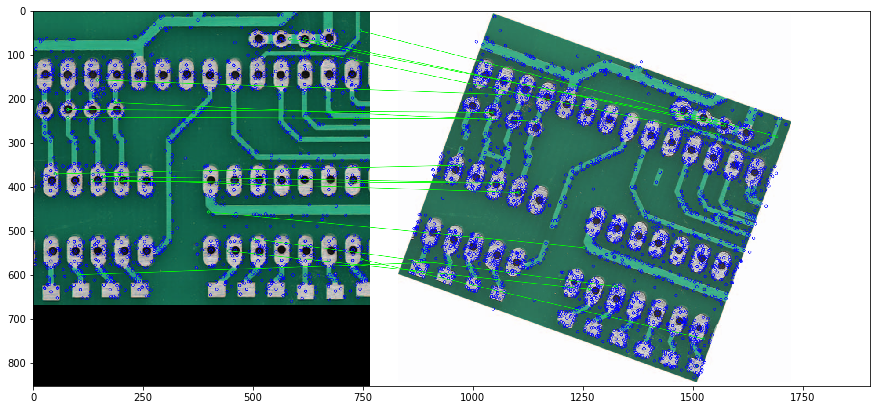

In [3]:
# 采用sift描述子,提取特征
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(src,None)
kp2, des2 = sift.detectAndCompute(dst,None)

# 快速估计最近邻的库匹配
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)
matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
good = sorted(matches, key = lambda x:x.distance)

# 得到求解透视变换的点
src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

# 求解模板图像到待检测图像的变换矩阵
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

# 变换矩阵计算得到掩码，然后再次优化输出的匹配点
matchesMask = mask.ravel().tolist()
draw_params = dict(matchColor=(0, 255, 0), singlePointColor=(0, 0, 255), matchesMask=matchesMask[:20])

img = cv2.drawMatches(src,kp1,dst,kp2,good[:20],None,**draw_params)

print('模板图像到待检测图像的变换矩阵：\n', M)
print('待检测图像匹配结果：')
plt.figure(figsize=(15, 15))
plt.imshow(img, 'gray')

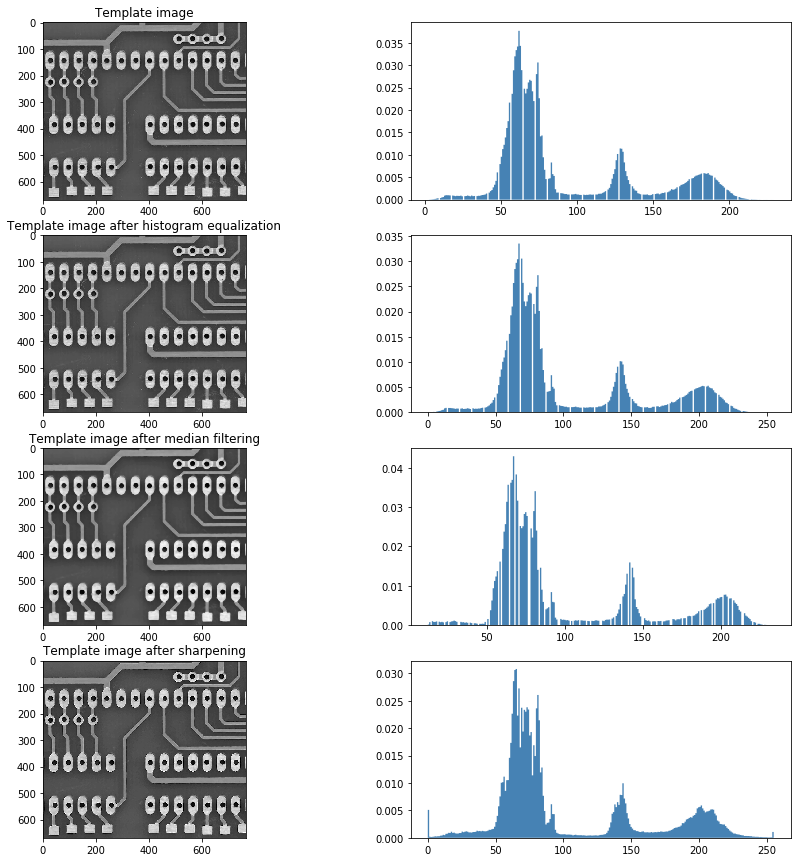

In [4]:
temp1 = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(15, 15))
plt.subplot(4, 2, 1)
plt.title('Template image')
plt.imshow(temp1, 'gray')
plt.subplot(4, 2, 2)
_ = plt.hist(temp1.reshape(-1), bins=256, density=True,histtype='stepfilled', color='steelblue')

# 直方图均衡化
temp1 = cv2.normalize(temp1,None,0,255,cv2.NORM_MINMAX)
plt.subplot(4, 2, 3)
plt.title('Template image after histogram equalization')
plt.imshow(temp1, 'gray')
plt.subplot(4, 2, 4)
_ = plt.hist(temp1.reshape(-1), bins=256, density=True,histtype='stepfilled', color='steelblue')

# 中值滤波
temp1 = cv2.medianBlur(temp1, 7)
plt.subplot(4, 2, 5)
plt.title('Template image after median filtering')
plt.imshow(temp1, 'gray')
plt.subplot(4, 2, 6)
_ = plt.hist(temp1.reshape(-1), bins=256, density=True,histtype='stepfilled', color='steelblue')

# 锐化
kernel = np.array([[0, -1, 0], 
                   [-1, 5, -1], 
                   [0, -1, 0]], dtype=np.float32)
temp1 = cv2.filter2D(temp1, -1, kernel)
plt.subplot(4, 2, 7)
plt.title('Template image after sharpening')
plt.imshow(temp1, 'gray')
plt.subplot(4, 2, 8)
_ = plt.hist(temp1.reshape(-1), bins=256, density=True,histtype='stepfilled', color='steelblue')

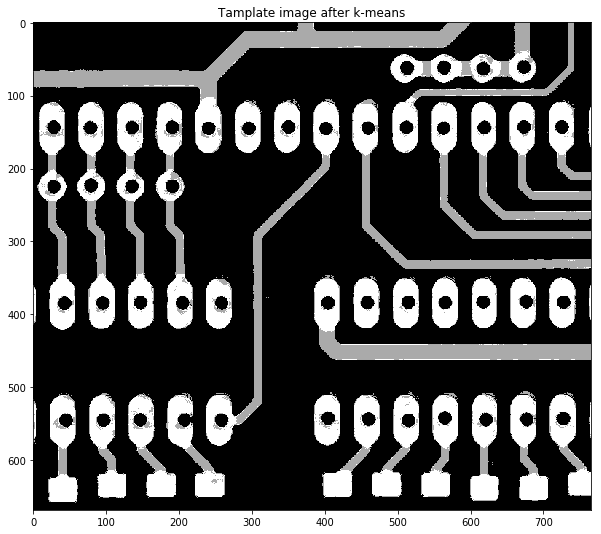

In [5]:
label = KMeans(n_clusters=3).fit_predict(temp1.reshape(-1, 1))  #图片聚成4类
label = label.reshape([rows,cols])
temp1 = np.zeros(temp1.shape, dtype='uint8')
for i in range(rows):                          #根据所属类别给图片添加灰度
    for j in range(cols):
        temp1[i, j] = int(256/(label[i][j] + 1))

plt.figure(figsize=(10, 10))
plt.title('Tamplate image after k-means')
plt.imshow(temp1, 'gray') 

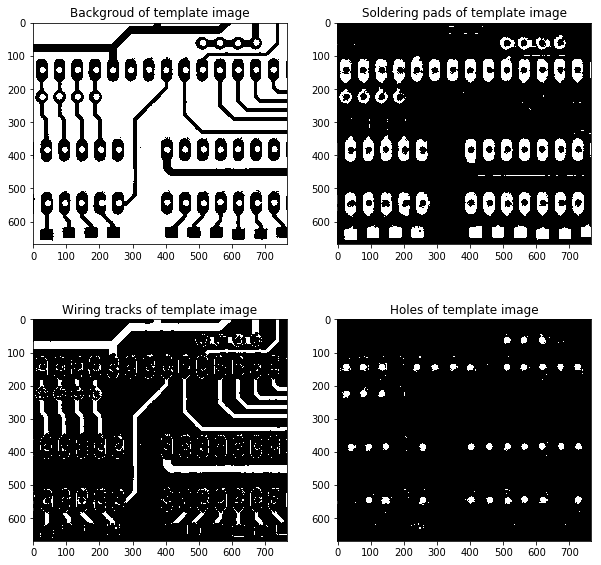

In [6]:
# 模板图像
# 根据所属类别给图片添加灰度
t1 = np.zeros(temp1.shape, dtype='uint8')
t2 = np.zeros(temp1.shape, dtype='uint8')
t3 = np.zeros(temp1.shape, dtype='uint8')
for i in range(rows):                          
    for j in range(cols):
        k = label[i][j]
        if k == 0:
            t1[i, j] = 255
        elif k == 1:
            t2[i, j] = 255
        elif k == 2:
            t3[i, j] = 255

# 聚类标签每次不一样，需要排序
if np.sum(t1==255) < np.sum(t2==255):
    t1, t2 = t2, t1
if np.sum(t2==255) < np.sum(t3==255):
    t2, t3 = t3, t2 
if np.sum(t1==255) < np.sum(t2==255):
    t1, t2 = t2, t1

# 分割出孔洞
t4 = t2.copy()
mask = np.zeros((rows+2, cols+2), np.uint8)
cv2.floodFill(t4, mask, (0,0), 255) # 满水填充
for i in range(rows):
    for j in range(cols):
        k = t4[i][j]
        if k == 0:
            t4[i, j] = 255
        else:
            t4[i, j] = 0

src_split = {'Backgroud': t1, 'Soldering pads': t2, 'Wiring tracks': t3, 'Holes': t4}

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.title('Backgroud of template image')
plt.imshow(src_split['Backgroud'], 'gray')
plt.subplot(2, 2, 2)
plt.title('Soldering pads of template image')
plt.imshow(src_split['Soldering pads'], 'gray')
plt.subplot(2, 2, 3)
plt.title('Wiring tracks of template image')
plt.imshow(src_split['Wiring tracks'], 'gray')
plt.subplot(2, 2, 4)
plt.title('Holes of template image')
plt.imshow(src_split['Holes'], 'gray')

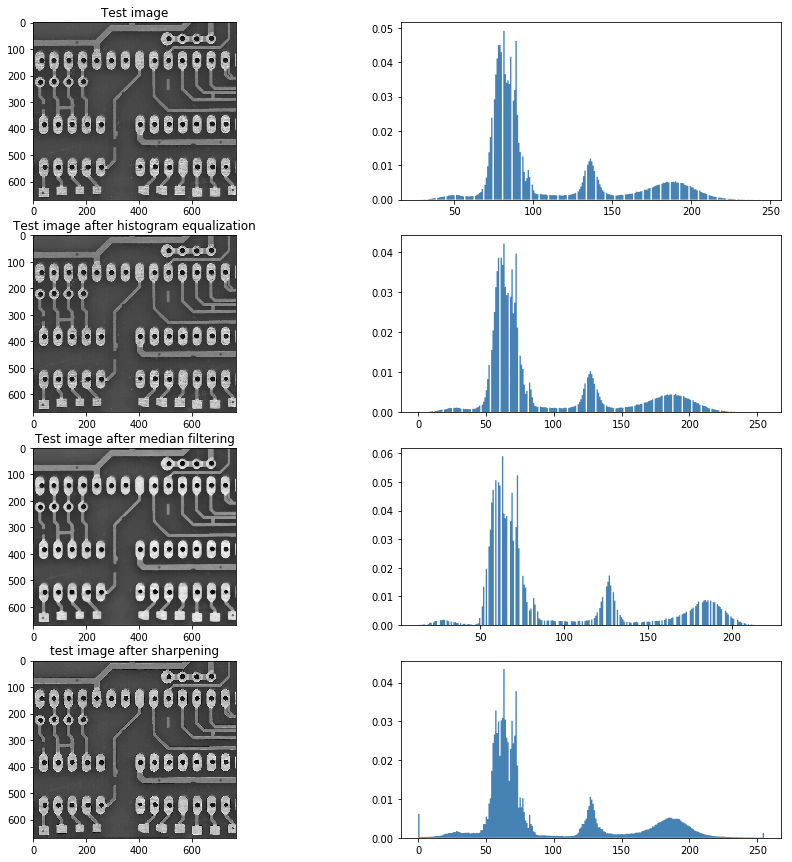

In [7]:
# 将目标图像投射到源图像坐标上，执行了一次M的求逆
result = cv2.warpPerspective(dst, np.mat(M).I, (cols, rows))
test = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(15, 15))
plt.subplot(4, 2, 1)
plt.title('Test image')
plt.imshow(test, 'gray')
plt.subplot(4, 2, 2)
_ = plt.hist(test.reshape(-1), bins=256, density=True,histtype='stepfilled', color='steelblue')

# 直方图均衡化
test = cv2.normalize(test,None,0,255,cv2.NORM_MINMAX)
plt.subplot(4, 2, 3)
plt.title('Test image after histogram equalization')
plt.imshow(test, 'gray')
plt.subplot(4, 2, 4)
_ = plt.hist(test.reshape(-1), bins=256, density=True,histtype='stepfilled', color='steelblue')

# 中值滤波
test = cv2.medianBlur(test, 7)
plt.subplot(4, 2, 5)
plt.title('Test image after median filtering')
plt.imshow(test, 'gray')
plt.subplot(4, 2, 6)
_ = plt.hist(test.reshape(-1), bins=256, density=True,histtype='stepfilled', color='steelblue')

# 锐化
kernel = np.array([[0, -1, 0], 
                   [-1, 5, -1], 
                   [0, -1, 0]], dtype=np.float32)
test = cv2.filter2D(test, -1, kernel)
plt.subplot(4, 2, 7)
plt.title('test image after sharpening')
plt.imshow(test, 'gray')
plt.subplot(4, 2, 8)
_ = plt.hist(test.reshape(-1), bins=256, density=True,histtype='stepfilled', color='steelblue')

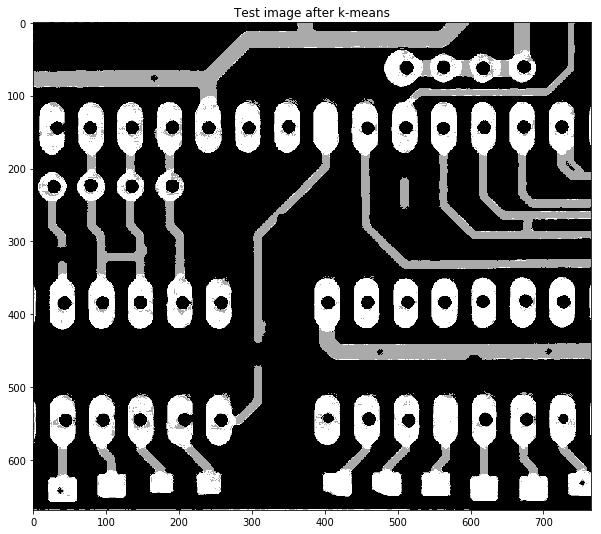

In [8]:
# test image k-means分割
label = KMeans(n_clusters=3).fit_predict(test.reshape(-1, 1))  #图片聚成4类
label = label.reshape([rows,cols])
test = np.zeros(test.shape, dtype='uint8')
for i in range(rows):                          #根据所属类别给图片添加灰度
    for j in range(cols):
        test[i, j] = int(256/(label[i][j] + 1))

plt.figure(figsize=(10, 10))
plt.title('Test image after k-means')
plt.imshow(test, 'gray')          

Test image:


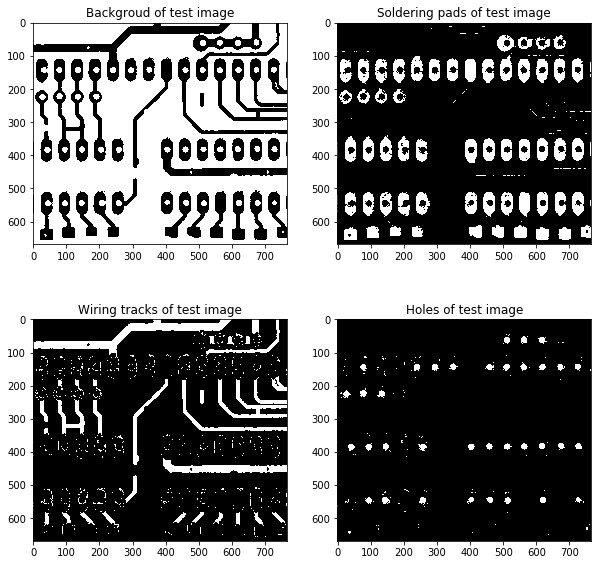

In [9]:
# 根据所属类别给图片添加灰度
t1 = np.zeros(test.shape, dtype='uint8')
t2 = np.zeros(test.shape, dtype='uint8')
t3 = np.zeros(test.shape, dtype='uint8')
for i in range(rows):                          
    for j in range(cols):
        k = label[i][j]
        if k == 0:
            t1[i, j] = 255
        elif k == 1:
            t2[i, j] = 255
        elif k == 2:
            t3[i, j] = 255

# 聚类标签每次不一样，需要排序
if np.sum(t1==255) < np.sum(t2==255):
    t1, t2 = t2, t1
if np.sum(t2==255) < np.sum(t3==255):
    t2, t3 = t3, t2 
if np.sum(t1==255) < np.sum(t2==255):
    t1, t2 = t2, t1
    


# 分割出孔洞
t4 = t2.copy()
mask = np.zeros((rows+2, cols+2), np.uint8)
cv2.floodFill(t4, mask, (0,0), 255) # 满水填充
for i in range(rows):
    for j in range(cols):
        k = t4[i][j]
        if k == 0:
            t4[i, j] = 255
        else:
            t4[i, j] = 0

test_split = {'Backgroud': t1, 'Soldering pads': t2, 'Wiring tracks': t3, 'Holes': t4}

print('Test image:')
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.title('Backgroud of test image')
plt.imshow(test_split['Backgroud'], 'gray')
plt.subplot(2, 2, 2)
plt.title('Soldering pads of test image')
plt.imshow(test_split['Soldering pads'], 'gray')
plt.subplot(2, 2, 3)
plt.title('Wiring tracks of test image')
plt.imshow(test_split['Wiring tracks'], 'gray')
plt.subplot(2, 2, 4)
plt.title('Holes of test image')
plt.imshow(test_split['Holes'], 'gray')

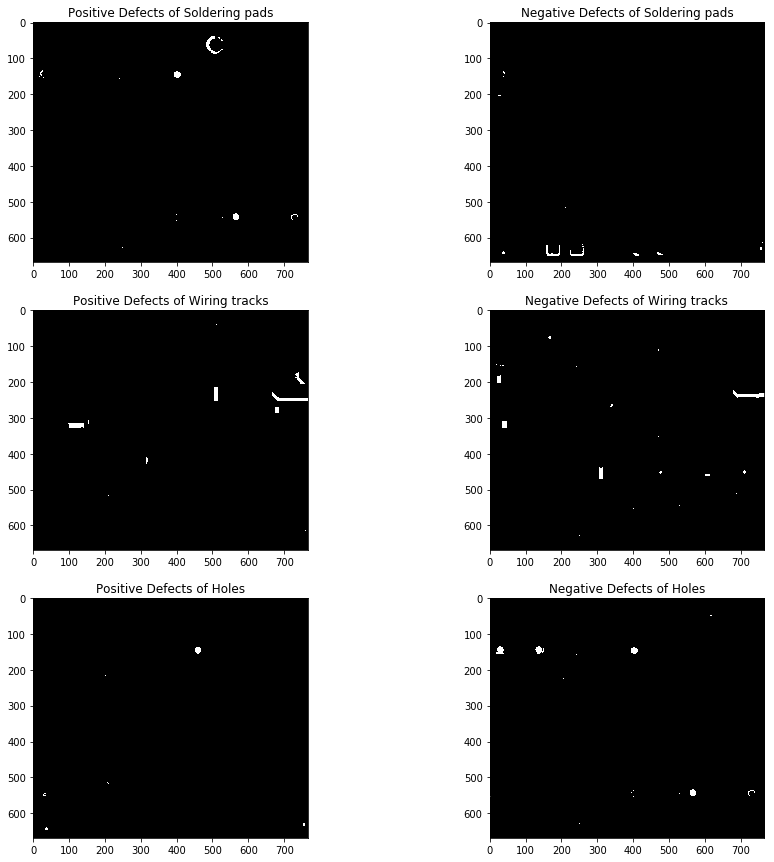

In [10]:
pd = [test_split['Soldering pads'] - src_split['Soldering pads'], 
      test_split['Wiring tracks'] - src_split['Wiring tracks'], 
      test_split['Holes'] - src_split['Holes']]
nd = [src_split['Soldering pads'] - test_split['Soldering pads'], 
      src_split['Wiring tracks'] - test_split['Wiring tracks'], 
      src_split['Holes'] - test_split['Holes']]
for i in range(3):
    for row in range(rows):
        for col in range(cols):
            if pd[i][row][col] != 255:
                pd[i][row][col] = 0

for i in range(3):
    for row in range(rows):
        for col in range(cols):
            if nd[i][row][col] != 255:
                nd[i][row][col] = 0

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
for i in range(3):
    pd[i] = cv2.erode(pd[i], kernel)
    pd[i] = cv2.dilate(pd[i], kernel)
for i in range(3):
    nd[i] = cv2.erode(nd[i], kernel)
    nd[i] = cv2.dilate(nd[i], kernel)

    
plt.figure(figsize=(15, 15))
plt.subplot(3, 2, 1)
plt.title('Positive Defects of Soldering pads')
plt.imshow(pd[0], 'gray')
plt.subplot(3, 2, 3)
plt.title('Positive Defects of Wiring tracks')
plt.imshow(pd[1], 'gray')
plt.subplot(3, 2, 5)
plt.title('Positive Defects of Holes')
plt.imshow(pd[2], 'gray')

plt.subplot(3, 2, 2)
plt.title('Negative Defects of Soldering pads')
plt.imshow(nd[0], 'gray')
plt.subplot(3, 2, 4)
plt.title('Negative Defects of Wiring tracks')
plt.imshow(nd[1], 'gray')
plt.subplot(3, 2, 6)
plt.title('Negative Defects of Holes')
plt.imshow(nd[2], 'gray')

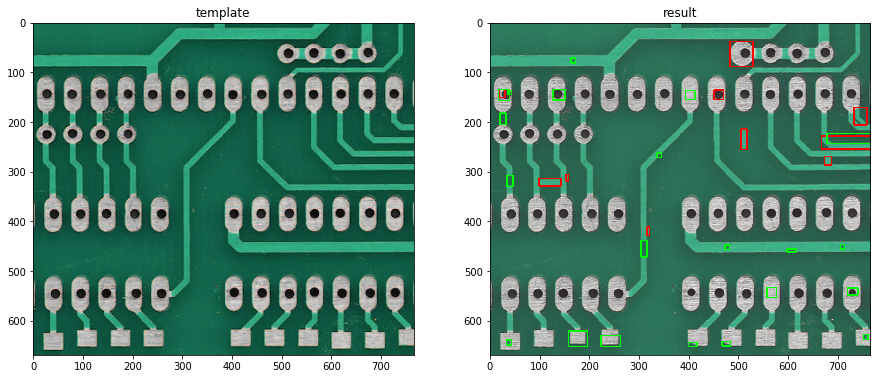

In [11]:
for m in range(len(pd)):
    _, contours, _ = cv2.findContours(pd[m], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for i in range(len(contours)): 
        if cv2.contourArea(contours[i]) < 20:
            continue
        x, y, w, h = cv2.boundingRect(contours[i])
        cv2.rectangle(result, (x, y), (x+w, y+h), (255, 0, 0), 2)

for m in range(len(nd)):
    _, contours, _ = cv2.findContours(nd[m], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for i in range(len(contours)): 
        if cv2.contourArea(contours[i]) < 20:
            continue
        x, y, w, h = cv2.boundingRect(contours[i])
        cv2.rectangle(result, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title('template')
plt.imshow(src)
plt.subplot(1, 2, 2)
plt.title('result')
plt.imshow(result)